## SKLearn Linear Regression with PCA



# PCA

In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split, KFold

In [74]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx",)

In [75]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


**Data Cleaning**

In [76]:
df.columns

Index(['No', 'X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

In [77]:
# Rename columns for convenience
df.columns = ['No', 'date','age','dist','stores','lat','long','price']

In [78]:
df.dtypes

No          int64
date      float64
age       float64
dist      float64
stores      int64
lat       float64
long      float64
price     float64
dtype: object

In [79]:
numerical_features = ['date','age','dist','lat','long']
target = 'price'

**Test/Train Split**

In [80]:
# Perform test/train split at 80/20 because we do not have much training data
df_train,df_test = train_test_split(df, test_size=0.2)

In [81]:
df_train.shape,df_test.shape

((331, 8), (83, 8))

**Feature creation**

In [82]:
poly = PolynomialFeatures(degree=4)

In [83]:
X_train = poly.fit_transform(df_train[numerical_features])

In [84]:
X_train.shape

(331, 126)

**Scaling**

In [85]:
scaler = MinMaxScaler()

In [86]:
X_train_scaled = scaler.fit_transform(X_train)

**Apply fitted coefficients to test set**

In [87]:
X_test = poly.transform(df_test[numerical_features])

In [88]:
X_test.shape

(83, 126)

In [89]:
X_test_scaled = scaler.transform(X_test)

**Linear Regression**

In [90]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [91]:
lr = LinearRegression()

In [92]:
lr.fit(X_train_scaled, y = df_train[target])

LinearRegression()

In [93]:
y_train_predict = lr.predict(X_train_scaled)

In [94]:
mean_absolute_error(y_train_predict, df_train[target])

4.703020410451283

In [95]:
y_test_predict = lr.predict(X_test_scaled)

In [96]:
mean_absolute_error(y_test_predict, df_test[target])

10.320826960184489

*Note that the error is high - let's try something else to reduce (PCA)*

**Side-track -- examine LR 'score'**

The LinearRegression 'score' function calculates 7 returns $R^2$, not the full result matrix.

This is another way to rate the quality of the LR results.

Here we run the score, then calculate the value ourselves.

In [97]:
# calc R^2
lr.score(X_train_scaled, df_train[target])

0.7574410227813075

In [98]:
mse_train = mean_squared_error(y_train_predict, df_train[target])
var_y = df_train[target].var()
r_squared = 1 - mse_train/var_y
# This should match the score pretty closely
r_squared

0.7581738293590075

**Use PCA to reduce the number of features**

In [99]:
from sklearn.decomposition import PCA

In [100]:
# We have 126 features right now
X_train_scaled.shape

(331, 126)

In [107]:
# Declare PCA with number of features to retain
pca = PCA(n_components=0.999)

In [118]:
# Fit the PCA with our training set
X_train_scaled_PCA = pca.fit_transform(X_train_scaled)

In [119]:
# How many components got retained?  Can adjust n_components to change this...
pca.n_components_

8

In [120]:
# Apply PCA to the test set
X_test_scaled_PCA = pca.transform(X_test_scaled)

**Try LR on the PCA'd datasets**

In [121]:
lr.fit(X_train_scaled_PCA, y = df_train[target])

LinearRegression()

In [122]:
y_train_predict_PCA = lr.predict(X_train_scaled_PCA)

In [123]:
mean_absolute_error(y_train_predict_PCA, df_train[target])

5.477296495060336

In [124]:
y_test_predict_PCA = lr.predict(X_test_scaled_PCA)

In [125]:
mean_absolute_error(y_test_predict_PCA, df_test[target])

6.606957661529527

*The test error has improved significantly.*

### Test Different PCA values

Just picking a range of values to try. Our initial case was ~8.

Here we'll go from 1-11, and accumulate and plot errors to compare.

In [126]:
training_error = {}
testing_error = {}


In [128]:
for i in range (1,11):
   pca = PCA(n_components=i)
   X_train_scaled_PCA = pca.fit_transform(X_train_scaled)
   X_test_scaled_PCA = pca.transform(X_test_scaled)
   lr.fit(X_train_scaled_PCA, y = df_train[target])
   y_train_predict_PCA = lr.predict(X_train_scaled_PCA)
   training_error[i] = mean_absolute_error(y_train_predict_PCA, df_train[target])
   y_test_predict_PCA = lr.predict(X_test_scaled_PCA)
   testing_error[i] = mean_absolute_error(y_test_predict_PCA, df_test[target])


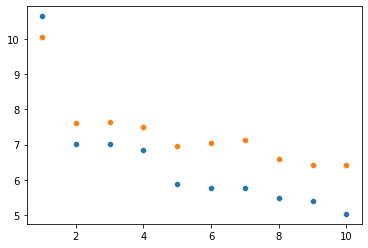

In [133]:
import seaborn as sns

sns.scatterplot(x=training_error.keys(), y=training_error.values())
sns.scatterplot(x=testing_error.keys(), y=testing_error.values())

**kfold CV, to reduce randomness in data.**

Compute the mean abs percentage deviation